In [1]:
import numpy as np 
import pandas as pd
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Rectangle
import sys
import xmltodict
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import time

In [2]:
torch.__version__

'1.9.0'

In [3]:
PATH_TO_DATASET = '../dataset'
PATH_TO_IMAGE = "../dataset/images"
PATH_TO_ANNOTATION = "../dataset/annotations"

In [4]:
def generate_box(obj):
    # print(obj)
    xmin = int(obj["bndbox"]["xmin"])
    ymin = int(obj["bndbox"]["ymin"])
    xmax = int(obj["bndbox"]["xmax"])
    ymax = int(obj["bndbox"]["ymax"])

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    """
    with mask -> 1
    wear incorrect or not wear -> 0
    """
    if obj["name"] == "with_mask":
        return 1
    else:
        return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = xmltodict.parse(f.read())
        
        objects = data["annotation"]["object"]
        
        # BBOX for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        if type(objects) == list:
            for i in objects:
                boxes.append(generate_box(i))
                labels.append(generate_label(i))
        else:
            boxes.append(generate_box(objects))
            labels.append(generate_label(objects))
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])
        
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [5]:
imgs = list(sorted(os.listdir(PATH_TO_IMAGE)))
annotations = list(sorted(os.listdir(PATH_TO_ANNOTATION)))
print(imgs[:3], annotations[:3])

['maksssksksss0.png', 'maksssksksss1.png', 'maksssksksss10.png'] ['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss10.xml']


In [6]:
class MaskDataset(Dataset):
    def __init__(self, transforms):
        super().__init__()
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(PATH_TO_IMAGE)))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(PATH_TO_IMAGE, file_image)
        label_path = os.path.join(PATH_TO_ANNOTATION, file_label)
        img = Image.open(img_path).convert("RGB")
        
        target = generate_target(idx, label_path)
        
        if self.transforms != None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [8]:
def collate_fn(batch):
    # print(*batch)
    return tuple(zip(*batch))

In [9]:
dataset = MaskDataset(data_transform)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
print(f"Dataset Length: {len(dataset)}, train_size: {train_size}, test_size: {test_size}")

Dataset Length: 853, train_size: 682, test_size: 171


In [10]:
trainset, testset=torch.utils.data.random_split(dataset, [train_size, test_size])

In [11]:
trainDataLoader = DataLoader(trainset, batch_size=8, shuffle=True, collate_fn=collate_fn)
testDataLoader = DataLoader(testset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [12]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
model = get_model_instance_segmentation(2)

In [15]:
for imgs, annotations in trainDataLoader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 17., 156.,  67., 206.],
        [102., 120., 159., 183.],
        [206., 117., 267., 185.]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([441])}, {'boxes': tensor([[168.,  76., 292., 211.]]), 'labels': tensor([1]), 'image_id': tensor([392])}, {'boxes': tensor([[ 26.,  92.,  44., 121.],
        [106.,  88., 122., 111.],
        [122., 102., 146., 124.],
        [151.,  73., 168.,  94.],
        [168.,  76., 190., 100.],
        [188.,  96., 219., 131.],
        [192.,  59., 210.,  78.],
        [223.,  53., 243.,  76.],
        [272.,  67., 291.,  88.],
        [260.,  93., 279., 115.],
        [288.,  86., 308., 113.],
        [348.,  71., 366.,  91.],
        [303.,  96., 330., 123.],
        [371.,  77., 396., 100.],
        [ 68.,  75.,  80.,  88.],
        [321.,  70., 333.,  84.],
        [367.,  67., 378.,  79.]]), 'labels': tensor([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]), 'image_id': tensor([388])}, {'boxes': tensor([[102., 141., 193., 250.]

## Train

In [16]:
num_epochs = 50
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
batches = len(trainDataLoader)
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start_time_epoch = time.time()
    for i, (imgs, annotations) in enumerate(trainDataLoader):
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        if i % 20 == 0:
            print(f"Epoch: {epoch}, Batch: {i}/{batches}, Loss: {losses}")
        epoch_loss += losses
    end_time_epoch = time.time()
    print(f"Epoch {epoch} total loss: {epoch_loss}, time: {end_time_epoch - start_time_epoch}")
    print("----------")

end_time = time.time()
print(f"Running time {end_time - start_time}")

torch.save(model.state_dict(),'./model1.pt')

/opt/homebrew/Caskroom/miniforge/base/envs/venv-conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, Batch: 20/86, Loss: 1.3556288480758667
Epoch: 0, Batch: 40/86, Loss: 0.02902762033045292
Epoch: 0, Batch: 60/86, Loss: 0.7619869709014893
Epoch: 0, Batch: 80/86, Loss: 0.8055102825164795
Epoch 0 total loss: 38.919708251953125, time: 350.72778701782227
----------
Epoch: 1, Batch: 20/86, Loss: 0.19597694277763367
Epoch: 1, Batch: 40/86, Loss: 0.47238633036613464
Epoch: 1, Batch: 60/86, Loss: 0.04668807610869408
Epoch: 1, Batch: 80/86, Loss: 0.16490291059017181
Epoch 1 total loss: 29.489219665527344, time: 356.857675075531
----------
Epoch: 2, Batch: 20/86, Loss: 0.8205618858337402
Epoch: 2, Batch: 40/86, Loss: 0.18008306622505188
Epoch: 2, Batch: 60/86, Loss: 0.08823470771312714
Epoch: 2, Batch: 80/86, Loss: 0.12880729138851166
Epoch 2 total loss: 24.46474838256836, time: 372.2149338722229
----------
Epoch: 3, Batch: 20/86, Loss: 0.08482053130865097
Epoch: 3, Batch: 40/86, Loss: 0.05436088144779205
Epoch: 3, Batch: 60/86, Loss: 0.14603838324546814
Epoch: 3, Batch: 80/86, Loss: 

KeyboardInterrupt: 

## Evaluation

In [17]:
model.load_state_dict(torch.load("./model1.pt"))

<All keys matched successfully>

In [29]:
for i, (imgs, annotations) in enumerate(testDataLoader):
    if i<11:
        continue
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    break
print(annotations)

[{'boxes': tensor([[ 29.,  90.,  60., 133.],
        [ 92.,  57., 128.,  88.],
        [ 26.,  42.,  45.,  61.],
        [123.,  12., 140.,  31.],
        [175.,  64., 196.,  86.],
        [203.,  50., 218.,  70.],
        [243.,  52., 257.,  74.],
        [218.,  91., 242., 117.],
        [231., 138., 255., 167.],
        [293.,  87., 320., 110.],
        [235.,   5., 246.,  21.],
        [323.,  25., 338.,  35.],
        [370.,  32., 398.,  63.],
        [184.,  18., 192.,  32.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'image_id': tensor([229])}]


In [30]:
model.eval()
preds = model(imgs)

In [31]:
preds

[{'boxes': tensor([[2.3136e+02, 1.3668e+02, 2.5483e+02, 1.6867e+02],
          [1.7408e+02, 6.1159e+01, 1.9553e+02, 8.8142e+01],
          [3.7034e+02, 3.0627e+01, 3.9516e+02, 6.2058e+01],
          [2.6028e+01, 4.1641e+01, 4.5045e+01, 6.0042e+01],
          [2.9252e+02, 8.3141e+01, 3.2095e+02, 1.1086e+02],
          [2.0344e+01, 9.1654e+01, 5.8301e+01, 1.3286e+02],
          [1.2395e+02, 9.6168e+00, 1.4103e+02, 2.9649e+01],
          [2.1668e+02, 8.8331e+01, 2.4105e+02, 1.1755e+02],
          [8.9989e+01, 5.3921e+01, 1.2628e+02, 8.8620e+01],
          [3.2290e+02, 2.0123e+01, 3.3691e+02, 3.5294e+01],
          [2.0091e+02, 4.7021e+01, 2.1741e+02, 6.9565e+01],
          [0.0000e+00, 9.9788e+01, 1.3075e+01, 1.2223e+02],
          [2.3383e+02, 4.4435e+00, 2.4534e+02, 1.9944e+01],
          [9.6308e+01, 1.2019e+02, 1.1712e+02, 1.3821e+02],
          [2.5645e+02, 5.5973e+01, 2.7692e+02, 7.7931e+01],
          [2.3814e+02, 7.8295e+00, 2.5366e+02, 2.9323e+01],
          [2.4132e+02, 5.3314e+

In [32]:
def plot_image(img_tensor, annotation):
    
    fig, ax = plt.subplots(1)
    img = img_tensor.cpu().data
    framecolor={1: 'g', 0: 'r',}

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box, label in zip(annotation["boxes"], annotation["labels"]):
        xmin, ymin, xmax, ymax = box
        xmin = float(xmin)
        ymin = float(ymin)
        xmax = float(xmax)
        ymax = float(ymax)
        label = int(label)
        # Create a Rectangle patch
        rect = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin,
                  linewidth=1, edgecolor=framecolor[label], facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


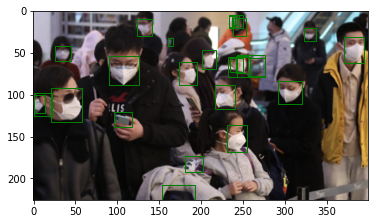

Target


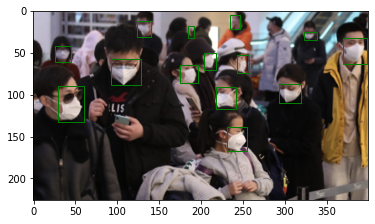

In [33]:
print("Prediction")
plot_image(imgs[0], preds[0])
print("Target")
plot_image(imgs[0], annotations[0])